In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pydicom as dicom
import pydicom
import json
import glob
import collections
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import plotly.graph_objects as go
import random
from glob import glob
import warnings
from PIL import Image
import tensorflow as tf
import ssl
from keras.src.layers import Flatten, Dense, Concatenate
from keras import Model, Input
from keras.src.utils import to_categorical
from keras.callbacks import Callback
import gc

In [2]:
# label_coordinates_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
# train_series = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
# df_train = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
# df_sub = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')
# test_series = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')

base_path = '/Volumes/SSD/rsna-2024-lumbar-spine-degenerative-classification'
train_png_file_path = f'{base_path}/train_dataset_png'

label_coordinates_df = pd.read_csv(f'{base_path}/train_label_coordinates.csv')
train_series = pd.read_csv(f'{base_path}/train_series_descriptions.csv')
df_train = pd.read_csv(f'{base_path}/train.csv')
df_sub = pd.read_csv(f'{base_path}/sample_submission.csv')
test_series = pd.read_csv(f'{base_path}/test_series_descriptions.csv')

train_dicom = f'{base_path}/train_images'
test_dicom = f'{base_path}/test_images'

model_path = f'model.keras'

In [3]:
test_series

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [15]:
# パラメータ
CROP_SIZE = 64
STUDY_NUM = 1975

# 出力のラベル
NORMAL_MILD = 0
MODERATE = 1
SEVERE = 2

# 重症度一覧
SEVERITY_LIST = ['Normal/Mild', 'Moderate', 'Severe']

# 学習用パラメータ
BATCH_SIZE = 2
EPOCHS = 50
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1

# 入出力の形状
INPUT_WIDTH = 512
INPUT_HEIGHT = 512
INPUT_CHANNEL = 20

In [5]:
train_series[train_series['study_id'] == 2492114990]

,study_id,series_id,series_description
3597,2492114990,1711913559,Axial T2
3598,2492114990,1753543608,Sagittal T2/STIR


In [6]:
_target_name = "right_subarticular_stenosis_l5_s1"

print(f'train shape : {df_train.shape}')
print(df_train[_target_name].unique())

# それぞれの重症度の数がいくらあるか計算
print(f'Normal/Mild : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0]}')
print(f'Moderate : {df_train[df_train[_target_name] == str("Moderate")].shape[0]}')
print(f'Severe : {df_train[df_train[_target_name] == str("Severe")].shape[0]}')

print(
    f'Normal/Mild ratio : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0] / df_train.shape[0]}')
print(
    f'Moderate ratio : {df_train[df_train[_target_name] == str("Moderate")].shape[0] / df_train.shape[0]}')
print(
    f'Severe ratio : {df_train[df_train[_target_name] == str("Severe")].shape[0] / df_train.shape[0]}')


train shape : (1975, 26)
['Normal/Mild' 'Moderate' 'Severe' nan]
Normal/Mild : 1399
Moderate : 396
Severe : 173
Normal/Mild ratio : 0.7083544303797469
Moderate ratio : 0.20050632911392405
Severe ratio : 0.08759493670886076


In [7]:
print(label_coordinates_df[label_coordinates_df['study_id'] == 4646740].shape)
label_coordinates_df[label_coordinates_df['study_id'] == 4646740]

(25, 7)


,study_id,series_id,instance_number,condition,level,x,y
25,4646740,3201256954,15,Right Subarticular Stenosis,L1/L2,184.180995,263.239819
26,4646740,3201256954,16,Left Subarticular Stenosis,L1/L2,235.317073,264.083624
27,4646740,3201256954,22,Left Subarticular Stenosis,L2/L3,235.317073,254.717770
28,4646740,3201256954,22,Right Subarticular Stenosis,L2/L3,200.977376,256.868778
29,4646740,3201256954,28,Right Subarticular Stenosis,L3/L4,204.452489,252.814480
30,4646740,3201256954,29,Left Subarticular Stenosis,L3/L4,233.979094,253.379791
31,4646740,3201256954,34,Left Subarticular Stenosis,L4/L5,222.606272,264.083624
32,4646740,3201256954,34,Right Subarticular Stenosis,L4/L5,188.814480,261.502262
33,4646740,3201256954,40,Left Subarticular Stenosis,L5/S1,209.226481,280.139373
34,4646740,3201256954,40,Right Subarticular Stenosis,L5/S1,172.597285,285.248869


In [8]:
label_coordinates_df.shape

(48692, 7)

In [9]:
def resize_volume_with_opencv(volume, new_shape):
    resized_volume = np.zeros((new_shape[0], new_shape[1], new_shape[2]), dtype=volume.dtype)

    for i in range(volume.shape[0]):
        resized_volume[i] = cv2.resize(volume[i], (new_shape[2], new_shape[1]),
                                       interpolation=cv2.INTER_LINEAR)

    return resized_volume


# serial 画像を一つの配列としてまとめる, (WIDTH, HEIGHT, CHANNEL)の形にする
def merge_dicom_images(study_id, series_id, file_kind='train',
                       image_size=(INPUT_WIDTH, INPUT_HEIGHT)):
    # 画像ファイルのパスを取得
    if file_kind == 'train':
        _file_path = f'{train_dicom}/{study_id}/{series_id}/*.dcm'
    else:
        _file_path = f'{test_dicom}/{study_id}/{series_id}/*.dcm'
    dicom_files = glob(_file_path)

    if len(dicom_files) == 0:
        raise ValueError('dicom file not found')

    images = []
    for file in dicom_files:
        # 画像ファイルを読み込む
        image = dicom.read_file(file).pixel_array

        # 0~1 に正規化
        image = image / np.max(image)

        # 0~255 にスケーリングして, int8 に変換
        image = (image * 255).astype(np.uint8)

        image = cv2.resize(image, (image_size[0], image_size[1])).astype(np.uint8)
        images.append(image)

    # 画像ファイルを読み込む
    images = np.array(images)

    # arrayの経常を変更
    images = images.transpose(1, 2, 0)

    return images


# dicom画像を指定した枚数に整形する
def reshape_dicom_img(dicom_img_array: np.ndarray, target_shape: int):
    channel = dicom_img_array.shape[2]
    output_dicom_img = dicom_img_array
    if channel < target_shape:
        # 画像の枚数が足りない場合は、最後の画像をコピーして追加
        padding_frame = np.zeros((dicom_img_array.shape[0], dicom_img_array.shape[1], 1)).astype(
            np.uint8)
        for i in range(target_shape - channel):
            output_dicom_img = np.append(output_dicom_img, padding_frame, axis=2)
    elif channel == target_shape:
        # 画像の枚数がちょうどの場合はそのまま返す
        pass
    else:
        # 画像の枚数が多い場合は、前からtarget_shape枚を取得
        output_dicom_img = output_dicom_img[:, :, :target_shape]

    return output_dicom_img


# 一つのstudy_id に複数のseries_id が存在する場合を見つける
def find_multi_series_study_id():
    multi_series_study_id = []
    for study_id in train_series['study_id'].unique():
        series_ids = train_series[train_series['study_id'] == study_id]['series_id']
        if len(series_ids) > 3:
            multi_series_study_id.append(study_id)
    return multi_series_study_id[0]


# 指定した study_id から 'Sagittal T1' 'Axial T2' 'Sagittal T2/STIR' の画像をそれぞれ取得
def get_dicom_img_set(study_id, file_kind='train'):
    # 画像の種類
    image_types = ['Sagittal T1', 'Axial T2', 'Sagittal T2/STIR']

    # study_id に対応する series_id を取得
    if file_kind == 'train':
        series_ids = train_series[train_series['study_id'] == study_id]
    else:
        series_ids = test_series[test_series['study_id'] == study_id]

    dicom_image_dict = {}
    for img_type in image_types:
        series_id = series_ids[series_ids['series_description'] == img_type]['series_id']

        dicom_image = np.zeros((INPUT_WIDTH, INPUT_HEIGHT, INPUT_CHANNEL)).astype(np.uint8)
        if len(series_id) != 0:
            # 画像を取得して整形
            dicom_image = merge_dicom_images(study_id, series_id.values[0], file_kind)
            dicom_image = reshape_dicom_img(dicom_image, INPUT_CHANNEL)
            print(f'{img_type} : {dicom_image.dtype}')
        dicom_image_dict[img_type] = dicom_image

    # numpy 配列に変換
    dicom_image_dict = np.array([dicom_image_dict['Sagittal T1'],
                                 dicom_image_dict['Axial T2'],
                                 dicom_image_dict['Sagittal T2/STIR']])

    return dicom_image_dict


# study_id を配列として取得
def get_study_id_array(file_kind='train') -> np.ndarray:
    if file_kind == 'train':
        _study_ids = train_series['study_id'].unique()
    else:
        _study_ids = test_series['study_id'].unique()
    return _study_ids


# 学習用データの study_id を取得
def get_train_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    train_study_ids = _study_ids[:int(len(_study_ids) * 0.8)]
    return train_study_ids


# 検証用データの study_id を取得
def get_valid_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    valid_study_ids = _study_ids[int(len(_study_ids) * 0.8):int(len(_study_ids) * 0.9)]
    return valid_study_ids


# テスト用データの study_id を取得 (実際のテストデータではなく, 学習データの一部をテストデータとして使用)
def get_test_study_id_array():
    _study_ids = train_series['study_id'].unique()
    print(f'start : {int(len(_study_ids) * 0.9)}')
    # 0.8 で分割
    test_study_ids = _study_ids[int(len(_study_ids) * 0.9):]
    return test_study_ids


# target 一覧を取得, targetに対して重症度が付与されている
def get_target_list():
    target_list = df_train.columns.to_list()[1:]
    return target_list


# study_id に対応する重症度一覧を取得する
def get_target_severity(study_id):
    target_severity = df_train[df_train['study_id'] == study_id].values[0][1:]
    output_severity = []
    # 文字列から数値に変換
    for i in range(len(target_severity)):
        if target_severity[i] == 'Normal/Mild':
            output_severity.append(NORMAL_MILD)
        elif target_severity[i] == 'Moderate':
            output_severity.append(MODERATE)
        elif target_severity[i] == 'Severe':
            output_severity.append(SEVERE)
        else:
            output_severity.append(NORMAL_MILD)

    return output_severity


# すべてのstudy_id に対して重症度を取得する
def get_all_target_severity(study_ids) -> np.ndarray:
    _target_severity_dict = []
    for study_id in study_ids.tolist():
        target_severity = get_target_severity(study_id)
        _target_severity_dict.append(target_severity)
    _target_severity_dict = np.array(_target_severity_dict)
    return _target_severity_dict


def get_target_severity_from_array(start, end):
    _target_severity_dict = []
    _study_ids = train_series['study_id'].unique()

    if end >= STUDY_NUM:
        end = STUDY_NUM - 1

    print(f'start : {start}, end : {end}, STUDY_NUM : {STUDY_NUM}')
    print(f'get_data_size : {end - start}')

    for study_id in _study_ids[start:end]:
        target_severity = get_target_severity(study_id)
        _target_severity_dict.append(target_severity)
    _target_severity_dict = np.array(_target_severity_dict)
    return _target_severity_dict


def get_target_severity_index(severity_index: int):
    _index = severity_index * 100
    _target_severity_dict = get_target_severity_from_array(_index, _index + 100)
    return _target_severity_dict


def get_target_severity_valid():
    _valid_study_ids = get_valid_study_id_array()
    _target_severity_dict = []
    for study_id in _valid_study_ids:
        target_severity = get_target_severity(study_id)
        _target_severity_dict.append(target_severity)
    _target_severity_dict = np.array(_target_severity_dict)
    return _target_severity_dict


def get_target_severity_test():
    _test_study_ids = get_test_study_id_array()
    _target_severity_dict = []
    for study_id in _test_study_ids:
        target_severity = get_target_severity(study_id)
        _target_severity_dict.append(target_severity)
    _target_severity_dict = np.array(_target_severity_dict)
    return _target_severity_dict


# すべてのstudy_id に対して 'Sagittal T1' 'Axial T2' 'Sagittal T2/STIR' の画像を取得する
def get_all_dicom_img_set(study_ids, file_kind='train') -> np.ndarray:
    dicom_img_sets = []
    for study_id in study_ids.tolist():
        print(f'[{study_id}] remaining : {len(study_ids) - study_ids.tolist().index(study_id)}')
        _dicom_img_set = get_dicom_img_set(study_id, file_kind)
        dicom_img_sets.append(_dicom_img_set)
    dicom_img_sets = np.array(dicom_img_sets)
    return dicom_img_sets


def show_dicom_img_from_array(dicom_img_sets, index):
    for i in range(3):
        plt.figure(figsize=(20, 20))
        for j in range(15):
            plt.subplot(3, 5, j + 1)
            plt.imshow(dicom_img_sets[0, i, :, :, j], cmap='gray')
        plt.show()


# dicom image を指定した範囲だけ取得する
def get_dicom_img_from_array(start, end):
    dicom_img_sets = []
    if end >= STUDY_NUM:
        end = STUDY_NUM - 1
    print(f'start : {start}, end : {end}, STUDY_NUM : {STUDY_NUM}')
    print(f'get_data_size : {end - start}')
    _study_ids = train_series['study_id'].unique()
    # 取得する範囲のstudy_id を取得
    process_study_ids = _study_ids[start:end]
    print(f'process_study_ids : {process_study_ids.shape}')

    for study_id in process_study_ids:
        print(f'[{study_id}] remaining : '
              f'{len(process_study_ids) - process_study_ids.tolist().index(study_id)}')
        _dicom_img_set = get_dicom_img_set(study_id)
        print(f'_dicom_img_set : {_dicom_img_set.dtype}')
        dicom_img_sets.append(_dicom_img_set)
    dicom_img_sets = np.array(dicom_img_sets)
    return dicom_img_sets

Sagittal T1 : uint8
Axial T2 : uint8
dicom_img_set : (3, 512, 512, 20)
dicom image type: uint8
dicom_img_set size : 0.01572864[GB]
dicom_img_set size : 31.064064[GB]


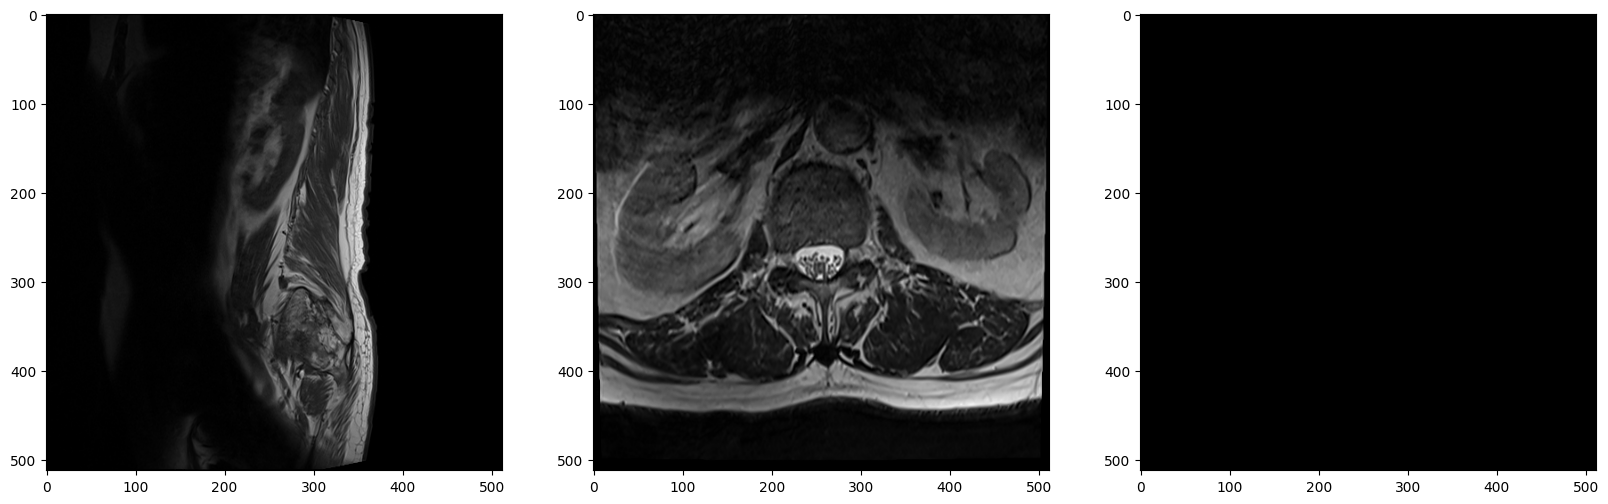

In [10]:
# dicom画像を取得, 情報を表示
dicom_img_set = get_dicom_img_set(3008676218)
print(f'dicom_img_set : {dicom_img_set.shape}')
print(f'dicom image type: {dicom_img_set.dtype}')

# dicom_img_setのサイズを取得 (byte)
print(f'dicom_img_set size : {dicom_img_set.nbytes / 1000000000}[GB]')

# データセット全体のサイズを取得 (byte)
print(f'dicom_img_set size : {dicom_img_set.nbytes * 1975 / (10 ** 9)}[GB]')

# 3 つの画像を表示
plt.subplots(1, 3, figsize=(20, 20))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(dicom_img_set[i, :, :, 9], cmap='gray')
plt.show()


In [ ]:
# すべてのstudy_idを取得する
study_ids = get_study_id_array()
print(f'study_ids : {study_ids.shape}')

# すべてのstudy_idに対して重症度を取得する. 今回は一つだけ分類するので、一つの重症度を取得する
target_severity_dict = get_all_target_severity(study_ids)
print(f'target_severity_dict : {target_severity_dict.shape}')

target_list = get_target_list()

In [ ]:
# すべてのstudy_idに対して 'Sagittal T1' 'Axial T2' 'Sagittal T2/STIR' の画像を取得する
# dicom_img_sets = get_all_dicom_img_set(study_ids)

# dicom画像を読み込む
# dicom_img_sets = np.load('dicom_img_set.npy')

In [ ]:
def convert_dicom_img_to_npy(index: int):
    start = index * 100
    end = index * 100 + 100
    num_of_train_study = len(get_train_study_id_array())

    # start が範囲外の場合は,処理を終了
    if start >= num_of_train_study:
        return

    if end >= num_of_train_study:
        end = num_of_train_study - 1
    print(f'start : {start}, end : {end}, num_of_train_study : {num_of_train_study}')

    dicom_img_sets = get_dicom_img_from_array(start, end)
    print(f'dicom_img_sets : {dicom_img_sets.shape}')
    print(f'dicom_img_sets : {dicom_img_sets.dtype}')
    np.save(f'{base_path}/train_dicom_img_sets_{index}.npy', dicom_img_sets)
    print(f'{base_path}/train_dicom_img_sets_{index}.npy saved')


# dicom画像を少しずつ読み込んで.npyに変換していく (train画像)
def convert_dicom_img_to_npy_all():
    train_study_ids = get_train_study_id_array()
    print(f'train_study_ids : {train_study_ids.shape}')
    train_study_id_num = len(train_study_ids)
    for i in range(11, train_study_id_num // 100 + 1):
        convert_dicom_img_to_npy(i)


In [ ]:
# train の対象になる範囲を表示
train_study_ids = get_train_study_id_array()
print(f'train_study_ids : {train_study_ids.shape}')

In [ ]:
# dicom画像を少しずつ読み込んで.npyに変換していく (valid画像)
def convert_dicom_img_to_npy_valid():
    valid_study_ids = get_valid_study_id_array()
    print(f'valid_study_ids : {valid_study_ids.shape}')
    valid_dicom_img_sets = get_all_dicom_img_set(valid_study_ids)
    np.save(f'{base_path}/valid_dicom_img_sets.npy', valid_dicom_img_sets)
    print(f'{base_path}/valid_dicom_img_sets.npy saved')

In [ ]:
# dicom画像を少しずつ読み込んで.npyに変換していく (test画像)
def convert_dicom_img_to_npy_test():
    test_study_ids = get_test_study_id_array()
    print(f'test_study_ids : {test_study_ids.shape}')
    test_dicom_img_sets = get_all_dicom_img_set(test_study_ids)
    np.save(f'{base_path}/test_dicom_img_sets.npy', test_dicom_img_sets)

In [ ]:
# 

In [ ]:
# dicom画像を保存する
# np.save('dicom_img_set.npy', dicom_img_sets)

In [ ]:
# train_index = 3

# # データを分割する
# train_data = np.load(f'{base_path}/train_dicom_img_sets_{train_index}.npy')
# # valid_data = np.load(f'{base_path}/valid_dicom_img_sets.npy')

# # test_data 
# print(f'train_data : {train_data.shape}')
# # print(f'valid_data : {valid_data.shape}')
# # print(f'test_data : {test_data.shape}')

# # 学習用データを取得
# train_sagittal_t1 = train_data[:, 0, :, :, :]
# train_axial_t2 = train_data[:, 1, :, :, :]
# train_sagittal_t2_stir = train_data[:, 2, :, :, :]

# print(f'train_sagittal_t1 : {train_sagittal_t1.shape}')
# print(f'train_axial_t2 : {train_axial_t2.shape}')
# print(f'train_sagittal_t2_stir : {train_sagittal_t2_stir.shape}')

# # 検証用データを取得
# # valid_sagittal_t1 = valid_data[:, 0, :, :, :]
# # valid_axial_t2 = valid_data[:, 1, :, :, :]
# # valid_sagittal_t2_stir = valid_data[:, 2, :, :, :]

# # テスト用データを取得
# # test_sagittal_t1 = test_data[:, 0, :, :, :]
# # test_axial_t2 = test_data[:, 1, :, :, :]
# # test_sagittal_t2_stir = test_data[:, 2, :, :, :]


# # 出力を分割
# train_target_severity = get_target_severity_index(train_index)
# # valid_target_severity = get_target_severity_valid()
# test_target_severity = get_target_severity_test()

# train_target_severity_list = [to_categorical(train_target_severity[:, i], num_classes=3) for i in
#                               range(25)]
# # valid_target_severity_list = [to_categorical(valid_target_severity[:, i], num_classes=3) for i in
# #                               range(25)]
# test_target_severity_list = [to_categorical(test_target_severity[:, i], num_classes=3) for i in
#                              range(25)]

# train_datasets = [train_sagittal_t1, train_axial_t2, train_sagittal_t2_stir]
# # valid_datasets = [valid_sagittal_t1, valid_axial_t2, valid_sagittal_t2_stir]

# del train_data
# # del valid_data
# gc.collect()

In [10]:
from keras.src import backend
from keras.src import layers
from keras.src.api_export import keras_export
from keras.src.applications import imagenet_utils
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils


def VGG16(
        include_top=True,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
):
    if not (weights in {"imagenet", None} or file_utils.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), 'imagenet' "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded.  Received: "
            f"weights={weights}"
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            "If using `weights='imagenet'` with `include_top=True`, "
            "`classes` should be 1000.  "
            f"Received classes={classes}"
        )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Get the number of input channels
    input_channels = input_shape[-1]
    # Block 1
    x = layers.Conv2D(
        64, (3, 3), activation="relu", padding="same", name="block1_conv1",
        input_shape=(None, None, input_channels)
    )(img_input)
    x = layers.Conv2D(
        64, (3, 3), activation="relu", padding="same", name="block1_conv2"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)

    # Block 2
    x = layers.Conv2D(
        128, (3, 3), activation="relu", padding="same", name="block2_conv1"
    )(x)
    x = layers.Conv2D(
        128, (3, 3), activation="relu", padding="same", name="block2_conv2"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = layers.Conv2D(
        256, (3, 3), activation="relu", padding="same", name="block3_conv1"
    )(x)
    x = layers.Conv2D(
        256, (3, 3), activation="relu", padding="same", name="block3_conv2"
    )(x)
    x = layers.Conv2D(
        256, (3, 3), activation="relu", padding="same", name="block3_conv3"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)

    # Block 4
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block4_conv1"
    )(x)
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block4_conv2"
    )(x)
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block4_conv3"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)

    # Block 5
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block5_conv1"
    )(x)
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block5_conv2"
    )(x)
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block5_conv3"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block5_pool")(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name="flatten")(x)
        x = layers.Dense(4096, activation="relu", name="fc1")(x)
        x = layers.Dense(4096, activation="relu", name="fc2")(x)

        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes, activation=classifier_activation, name="predictions"
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = operation_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Functional(inputs, x, name="vgg16")
    return model

In [11]:
# VGG16エンコーダを準備
def create_vgg_encoder(input_shape):
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg_base.layers:
        layer.trainable = False
    flatten = Flatten()(vgg_base.output)
    model = Model(inputs=vgg_base.input, outputs=flatten)
    return model


def create_model(input_shape):
    # 2つのVGGエンコーダを作成
    vgg_encoder1 = create_vgg_encoder(input_shape)
    vgg_encoder2 = create_vgg_encoder(input_shape)
    vgg_encoder3 = create_vgg_encoder(input_shape)

    # 入力の定義
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)
    input3 = Input(shape=input_shape)

    # VGGエンコーダーの出力を取得
    features1 = vgg_encoder1(input1)
    features2 = vgg_encoder2(input2)
    features3 = vgg_encoder3(input3)

    # 特徴ベクトルを結合
    combined_features = Concatenate()([features1, features2, features3])

    # 分類器を作成
    x = Dense(256, activation='relu')(combined_features)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)

    outputs = []
    metrics = {}
    target_list = get_target_list()
    for target_name in target_list:
        print(f'target_name : {target_name}')
        outputs.append(Dense(3, activation='softmax', name=target_name)(x))
        metrics[target_name] = 'accuracy'

    # モデルを定義
    model = Model(inputs=[input1, input2, input3], outputs=outputs)

    # モデルのコンパイル
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=metrics)

    # モデルのサマリーを表示
    model.summary()

    return model

In [12]:
input_shape = (INPUT_WIDTH, INPUT_HEIGHT, INPUT_CHANNEL)
print(f'input_shape : {input_shape}')
model = create_model(input_shape)

input_shape : (512, 512, 20)


/Users/toru/project/til/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-24 21:25:36.237969: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-24 21:25:36.237992: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-24 21:25:36.237997: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-24 21:25:36.238032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-24 21:25:36.238050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

target_name : spinal_canal_stenosis_l1_l2
target_name : spinal_canal_stenosis_l2_l3
target_name : spinal_canal_stenosis_l3_l4
target_name : spinal_canal_stenosis_l4_l5
target_name : spinal_canal_stenosis_l5_s1
target_name : left_neural_foraminal_narrowing_l1_l2
target_name : left_neural_foraminal_narrowing_l2_l3
target_name : left_neural_foraminal_narrowing_l3_l4
target_name : left_neural_foraminal_narrowing_l4_l5
target_name : left_neural_foraminal_narrowing_l5_s1
target_name : right_neural_foraminal_narrowing_l1_l2
target_name : right_neural_foraminal_narrowing_l2_l3
target_name : right_neural_foraminal_narrowing_l3_l4
target_name : right_neural_foraminal_narrowing_l4_l5
target_name : right_neural_foraminal_narrowing_l5_s1
target_name : left_subarticular_stenosis_l1_l2
target_name : left_subarticular_stenosis_l2_l3
target_name : left_subarticular_stenosis_l3_l4
target_name : left_subarticular_stenosis_l4_l5
target_name : left_subarticular_stenosis_l5_s1
target_name : right_subarticul

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 131072)    │ 14,724,480 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 131072)    │ 14,724,480 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 131072)    │ 14,724,480 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 393216)    │          0 │ functional_1[0][… │
│ (Concatenate)       │                   │            │ functional_3[0][… │
│                     │                   │            │ functional_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 100,663,5… │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spinal_canal_steno… │ (None, 3)         │        387 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spinal_canal_steno… │ (None, 3)         │        387 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spinal_canal_steno… │ (None, 3)         │        387 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spinal_canal_steno… │ (None, 3)         │        387 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spinal_canal_steno… │ (None, 3)         │        387 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left_neural_forami… │ (None, 3)         │        387 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left_neural_forami… │ (None, 3)         │        387 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 144,945,355 (552.92 MB)

 Trainable params: 100,771,915 (384.41 MB)

 Non-trainable params: 44,173,440 (168.51 MB)

In [13]:
class CustomCheckpoint(Callback):
    def __init__(self, filepath, period=1):
        super(CustomCheckpoint, self).__init__()
        self.filepath = filepath
        self.period = period

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            self.model.save_weights(self.filepath, overwrite=True)
            print(f'Saved model to {self.filepath}')


# カスタムチェックポイントのコールバックを作成
custom_checkpoint = CustomCheckpoint(filepath='model_checkpoint.keras', period=50)

In [14]:
model.load_weights(model_path)

/Users/toru/project/til/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
# 学習
valid_data = np.load(f'{base_path}/valid_dicom_img_sets.npy')
# 検証用データを取得
valid_sagittal_t1 = valid_data[:, 0, :, :, :]
valid_axial_t2 = valid_data[:, 1, :, :, :]
valid_sagittal_t2_stir = valid_data[:, 2, :, :, :]

valid_target_severity = get_target_severity_valid()
valid_datasets = [valid_sagittal_t1, valid_axial_t2, valid_sagittal_t2_stir]
valid_target_severity_list = [to_categorical(valid_target_severity[:, i], num_classes=3) for i in
                              range(25)]

del valid_data
gc.collect()

for i in range(15):
  train_index = i

  # データを分割する
  train_data = np.load(f'{base_path}/train_dicom_img_sets_{train_index}.npy')

  # test_data 
  print(f'train_data : {train_data.shape}')
  # print(f'valid_data : {valid_data.shape}')
  # print(f'test_data : {test_data.shape}')

  # 学習用データを取得
  train_sagittal_t1 = train_data[:, 0, :, :, :]
  train_axial_t2 = train_data[:, 1, :, :, :]
  train_sagittal_t2_stir = train_data[:, 2, :, :, :]

  print(f'train_sagittal_t1 : {train_sagittal_t1.shape}')
  print(f'train_axial_t2 : {train_axial_t2.shape}')
  print(f'train_sagittal_t2_stir : {train_sagittal_t2_stir.shape}')


  # テスト用データを取得
  # test_sagittal_t1 = test_data[:, 0, :, :, :]
  # test_axial_t2 = test_data[:, 1, :, :, :]
  # test_sagittal_t2_stir = test_data[:, 2, :, :, :]


  # 出力を分割
  train_target_severity = get_target_severity_index(train_index)
  # test_target_severity = get_target_severity_test()

  train_target_severity_list = [to_categorical(train_target_severity[:, i], num_classes=3) for i in
                                range(25)]

  # test_target_severity_list = [to_categorical(test_target_severity[:, i], num_classes=3) for i in
                              #  range(25)]

  train_datasets = [train_sagittal_t1, train_axial_t2, train_sagittal_t2_stir]

  del train_data
  gc.collect()
  history = model.fit(train_datasets, train_target_severity_list, batch_size=BATCH_SIZE,
                      epochs=20,
                      callbacks=[custom_checkpoint],
                      validation_data=(valid_datasets, valid_target_severity_list)
                      )
  
  # このループで取得した train データを削除
  del train_sagittal_t1
  del train_axial_t2
  del train_sagittal_t2_stir
  del train_target_severity
  del train_target_severity_list
  del train_datasets
  gc.collect()

train_data : (100, 3, 512, 512, 20)
train_sagittal_t1 : (100, 512, 512, 20)
train_axial_t2 : (100, 512, 512, 20)
train_sagittal_t2_stir : (100, 512, 512, 20)
start : 0, end : 100, STUDY_NUM : 1975
get_data_size : 100
Epoch 1/20


2024-06-24 21:26:25.042041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-24 21:26:26.305223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - left_neural_foraminal_narrowing_l1_l2_accuracy: 0.9673 - left_neural_foraminal_narrowing_l2_l3_accuracy: 0.8390 - left_neural_foraminal_narrowing_l3_l4_accuracy: 0.6906 - left_neural_foraminal_narrowing_l4_l5_accuracy: 0.5340 - left_neural_foraminal_narrowing_l5_s1_accuracy: 0.5801 - left_subarticular_stenosis_l1_l2_accuracy: 0.9567 - left_subarticular_stenosis_l2_l3_accuracy: 0.8205 - left_subarticular_stenosis_l3_l4_accuracy: 0.7144 - left_subarticular_stenosis_l4_l5_accuracy: 0.5116 - left_subarticular_stenosis_l5_s1_accuracy: 0.6709 - loss: 15.1804 - right_neural_foraminal_narrowing_l1_l2_accuracy: 0.9197 - right_neural_foraminal_narrowing_l2_l3_accuracy: 0.9019 - right_neural_foraminal_narrowing_l3_l4_accuracy: 0.7995 - right_neural_foraminal_narrowing_l4_l5_accuracy: 0.5248 - right_neural_foraminal_narrowing_l5_s1_accuracy: 0.6001 - right_subarticular_stenosis_l1_l2_accuracy: 0.9639 - right_subarticular_stenosis_l2_l3_accuracy: 0.8716 - 

2024-06-24 21:26:50.918514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 904ms/step - left_neural_foraminal_narrowing_l1_l2_accuracy: 0.9673 - left_neural_foraminal_narrowing_l2_l3_accuracy: 0.8398 - left_neural_foraminal_narrowing_l3_l4_accuracy: 0.6914 - left_neural_foraminal_narrowing_l4_l5_accuracy: 0.5345 - left_neural_foraminal_narrowing_l5_s1_accuracy: 0.5815 - left_subarticular_stenosis_l1_l2_accuracy: 0.9565 - left_subarticular_stenosis_l2_l3_accuracy: 0.8203 - left_subarticular_stenosis_l3_l4_accuracy: 0.7145 - left_subarticular_stenosis_l4_l5_accuracy: 0.5108 - left_subarticular_stenosis_l5_s1_accuracy: 0.6714 - loss: 15.1772 - right_neural_foraminal_narrowing_l1_l2_accuracy: 0.9199 - right_neural_foraminal_narrowing_l2_l3_accuracy: 0.9023 - right_neural_foraminal_narrowing_l3_l4_accuracy: 0.7995 - right_neural_foraminal_narrowing_l4_l5_accuracy: 0.5259 - right_neural_foraminal_narrowing_l5_s1_accuracy: 0.6021 - right_subarticular_stenosis_l1_l2_accuracy: 0.9638 - right_subarticular_stenosis_l2_l3_accuracy: 0.8710 -

In [ ]:
model.save('model.keras')

In [ ]:
# 学習結果をプロット
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
model.load_weights('model.keras')
test_dataset = np.load(f'{base_path}/test_dicom_img_sets.npy')

# テスト用データを取得
test_sagittal_t1 = test_dataset[:, 0, :, :, :]
test_axial_t2 = test_dataset[:, 1, :, :, :]
test_sagittal_t2_stir = test_dataset[:, 2, :, :, :]
test_datasets = [test_sagittal_t1, test_axial_t2, test_sagittal_t2_stir]
# testデータで予測
model.load_weights('model.keras')
test_predict = model.predict(test_datasets)

In [ ]:
print(np.array(test_predict).shape)
print(test_dataset.shape)
test_target_severity_list = get_target_severity_test()
test_predict_array = np.array(test_predict)
print(f'test_target_severity_list : {test_target_severity_list.shape}')
print(f'test_predict_array : {test_predict_array.shape}')

# arrayを並び替え
test_predict_array = test_predict_array.transpose(1, 0, 2)
print(f'test_predict_array : {test_predict_array.shape}')

In [ ]:

# 正答率を計算
correct_count = 0

# 重症度が高いものの正答率を計算
high_severity_correct_count = 0
high_severity_count = 0

# ターゲットの名前一覧
target_name_list = df_train.columns.to_list()[1:]
print(f'target_name_list : {target_name_list}')

# ターゲットごとの正答率を求めるため正答数をカウント
target_correct_count = {}
for name in target_name_list:
    target_correct_count[name] = 0

# サイズを表示
print(f'test_target_severity_list : {test_target_severity_list.shape}')
print(f'test_predict_array : {test_predict_array.shape}')

for i in range(test_target_severity_list.shape[0]):
    for j in range(25):
        target_name = target_name_list[j]
        # print(f'i, j : {i}, {j}')
        # print(f'test_target_severity_list : {test_target_severity_list[i][j]}')
        # print(f'test_predict : {np.argmax(test_predict_array[i][j])}')
        if test_target_severity_list[i][j] == np.argmax(test_predict_array[i][j]):
            correct_count += 1
            target_correct_count[target_name] += 1

        # 重症度が高いものの正答率を計算
        if (test_target_severity_list[i][j] == SEVERE or
                test_target_severity_list[i][j] == MODERATE):
            high_severity_count += 1
            if test_target_severity_list[i][j] == np.argmax(test_predict_array[i][j]):
                high_severity_correct_count += 1

print(f'correct_count : {correct_count}')
print(f'len(test_target_severity_list) : {(test_target_severity_list.shape[0] * 25)}')

accuracy = correct_count / (test_target_severity_list.shape[0] * 25)
print(f'accuracy : {accuracy}')

# ターゲットごとの正答率を表示
for name in target_name_list:
    target_accuracy = target_correct_count[name] / test_target_severity_list.shape[0]
    print(f'{name} : {target_accuracy}')

if high_severity_count != 0:
    print(f'high_severity_count : {high_severity_count}')
    high_severity_accuracy = high_severity_correct_count / high_severity_count
    print(f'high_severity_accuracy : {high_severity_accuracy}')


In [ ]:
# acc の変異を出力する
for key, value in history.history.items():
    print(key)
    plt.plot(value, label=key)
    plt.legend()
    plt.show()

In [ ]:
# kaggle が提供しているテストデータからsubmissionを作成する
def submission():
    model.load_weights(model_path)
    print(test_series)

    # テストデータの study_id 一覧を取得
    test_study_ids = test_series['study_id'].unique()

    # 提出用のデータを作成 (row_id,normal_mild,moderate,severe)
    submission_df = pd.DataFrame(columns=['row_id', 'normal_mild', 'moderate', 'severe'])

    # testデータのdicom画像一覧を取得
    for study_id in test_study_ids:
        print(
            f'[{study_id}] remaining : {len(test_study_ids) - test_study_ids.tolist().index(study_id)}')
        test_dicom_image_list = []
        test_dicom_image_list.append(get_dicom_img_set(study_id, 'test'))
        test_dicom_image_list = np.array(test_dicom_image_list)
        print(f'test_dicom_image_list : {test_dicom_image_list.shape}')

        lb_dataset = [
            test_dicom_image_list[:, 0, :, :, :],
            test_dicom_image_list[:, 1, :, :, :],
            test_dicom_image_list[:, 2, :, :, :],
        ]

        # テストデータを予測
        test_predict = model.predict(lb_dataset)
        test_predict_array = np.array(test_predict)

        # 並び替え
        test_predict_array = test_predict_array.transpose(1, 0, 2)

        print(f'test_predict_array : {test_predict_array.shape}')

        # ターゲットの名前一覧
        target_name_list = df_train.columns.to_list()[1:]

        for i in range(test_predict_array.shape[0]):
            for j in range(25):
                # row_id の戦闘に study_id を追加
                row_id = f'{test_study_ids[i]}_{target_name_list[j]}'
                normal_mild = test_predict_array[i][j][0].round(5)
                moderate = test_predict_array[i][j][1].round(5)
                severe = test_predict_array[i][j][2].round(5)
                submission_df.loc[len(submission_df)] = [row_id, normal_mild, moderate, severe]

        # メモリ解放
        test_dicom_image_list = None
        del test_dicom_image_list
        gc.collect()

    # 提出用のデータを保存
    submission_df.to_csv('submission.csv', index=False)


submission()

In [ ]:
# submission を表示
submission_df = pd.read_csv('submission.csv')
submission_df